# Проект: Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     GridSearchCV)
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np

## Первичный анализ данных и план проекта
В нашем распоряжении 7 таблиц с данными, которые необходимо проанализировать

### Данные об электродах

In [2]:
arc = pd.read_csv('datasets/data_arc_new.csv')
arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [3]:
arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


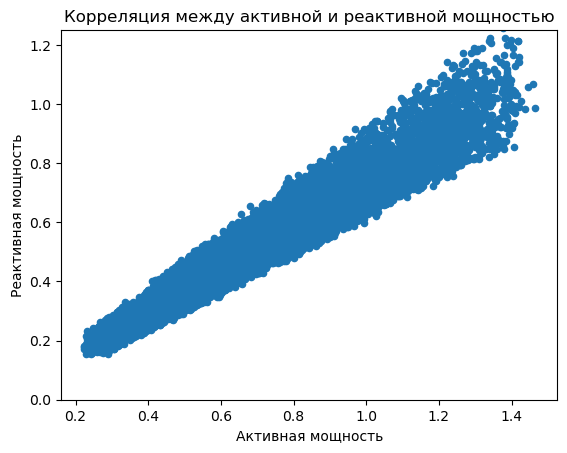

0.9663734456187298

In [5]:
arc.plot(x='Активная мощность', y = 'Реактивная мощность', ylim=[0, 1.25], kind="scatter")
plt.title('Корреляция между активной и реактивной мощностью')
plt.show()

arc[arc['Реактивная мощность']>0]['Активная мощность'].corr(arc[arc['Реактивная мощность']>0]['Реактивная мощность'])

В таблице представлены 3241 партия. Есть явная ошибка в виде отрицательной реактивной мощности, её необходимо удалить или восстановить, зная примерный коэффициент пропорциональности. Пропусков нет. Между активной и реактивной мощностью сильная корреляция, поэтому для формирования признаков необходимо взять что-то одно

### Данные о подаче сыпучих материалов

In [6]:
bulk = pd.read_csv('datasets/data_bulk_new.csv')
bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [7]:
bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [8]:
bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В таблице предстевлено 3129 партий и 15 видов сыпучих материалов. Пропуски можно заполнить нулями, это будет означать, что данный сыпучий материал не подавался в партию. Аномалий в виде отрицательных значений нет

#### Данные о подаче сыпучих материалов (время)

In [9]:
bulk_time = pd.read_csv('datasets/data_bulk_time_new.csv')
bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


Идентичная таблица, но вместо условных единиц объёма - время

### Данный о продувке сплава газом

In [10]:
gas = pd.read_csv('datasets/data_gas_new.csv')
gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [11]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [12]:
gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


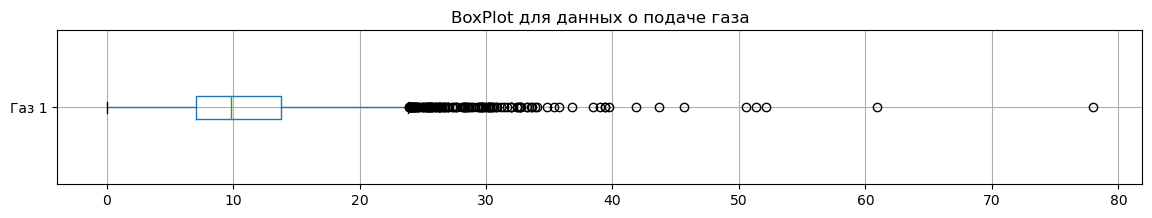

In [13]:
gas.boxplot(column="Газ 1", vert=False, figsize=(14, 2))
plt.title("BoxPlot для данных о подаче газа")
plt.show()

В таблице данные для 3239 партий. Пропущенных значений нет. Есть много выбросов, для обучающей выборки их можно удалить

### Результаты измерения температуры

In [14]:
temp = pd.read_csv('datasets/data_temp_new.csv')
temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [15]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [16]:
temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


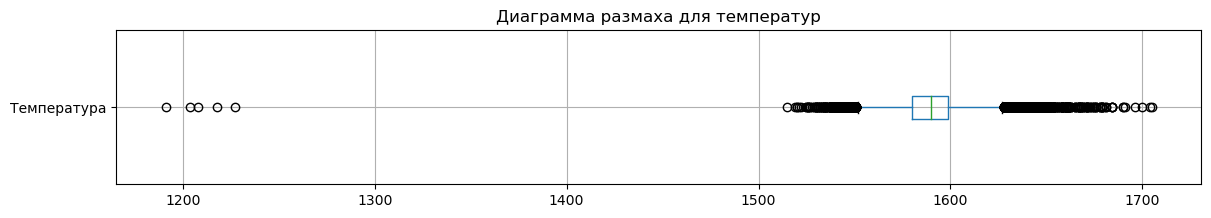

In [17]:
temp.boxplot(column="Температура", vert=False, figsize=(14,2))
plt.title("Диаграмма размаха для температур")
plt.show()

array([[<AxesSubplot:title={'center':'Температура'}>]], dtype=object)

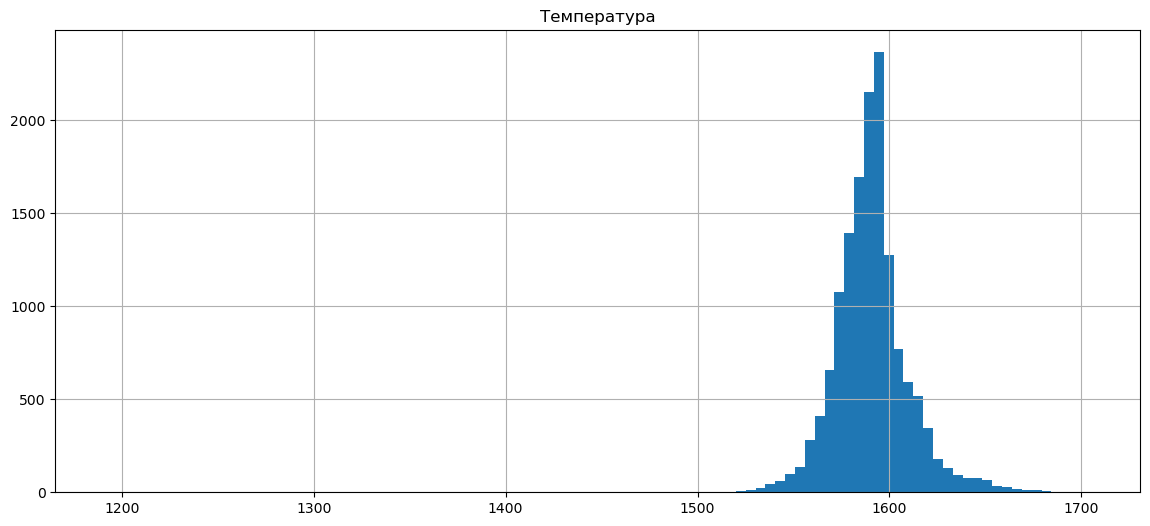

In [18]:
temp.hist(column='Температура', bins=100, figsize=(14, 6))

Представлены данные для 3241 партии. Есть пропуски в столбце с температурой, если пропущен какой-либо замер из партии, то придётся удалить всю партию. Существует небольшое число выбросов в сторону низкой температуры (ниже температуры плавления), партии с такими аномалиями придется удалить. Остальные температуры распределены вокруг отметки примерно в 1590-1600 градусов, что выше температуры плавления

### Данные о проволочных материалах

In [19]:
wire = pd.read_csv('datasets/data_wire_new.csv')
wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [21]:
wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


В данной таблице представлены данные для 3081 партии. Много пропущеных значений, который, как и в предыдущем случае, можно заполнить нулями.

#### Данные о проволочных материалах (время)

In [22]:
wire_time = pd.read_csv('datasets/data_wire_time_new.csv')
wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### План проекта

1. Предобработка данных

   На данном этапе необходимо избавиться от пропусков, аномальных значений и ошибок измерений. При этом, если удаляется одна запись из партии, то необходимо удалить всю партию
   
   
2. Выбор (или формирование) набора признаков и целевого признака. Агрегирование в итоговый датафрейм

   Необходимо предсказать конечную температуру - это целевой признак. Нужно выяснить, что может влиять на целевой признак - это и будет набором признаков
   
   
3. Разделение на обучающую и тестовую выборки

   При этом обучающую выборку желательно сделать "хорошей" - без выбросов и аномалий, в таком случае тестовую нужно оставить "реальной"
   
   
4. Обучение и выбор лучшей модели кросс-валидацией


5. Тестирование модели 

### Вопросы бизнесу

Предполагается ли, что человек, который будет вводить в модель данные, чтоб получить предсказание, знает эти самые данные?
Если предсказание получают до начала изготовления стали, будет ли считаться известной энергия, затраченная на изготовление? Иными словами, есть ли ограничения на формирование фич?

## Решение задачи

### Формирование набора признаков

#### Данные об электродах
Восстановим аномальное значение с помощью коэффициента пропорциональности двух мощностей

In [23]:
a = 'Активная мощность'
r = 'Реактивная мощность'
arc.loc[arc[r]<0, r] = arc[arc[r]<0][a]*((arc[arc[r]>0][r]/arc[arc[r]>0][a]).mean())

В качестве признака возьмем суммарную активную энергию, затраченную на нагрев стали. Для этого необходимо знать общее время нагрева для каждой партии

In [24]:
arc['Время нагрева'] = \
(pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S') - \
pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')).dt.total_seconds()
arc['Время нагрева'].head(5)

0    228.0
1    185.0
2    172.0
3    365.0
4    148.0
Name: Время нагрева, dtype: float64

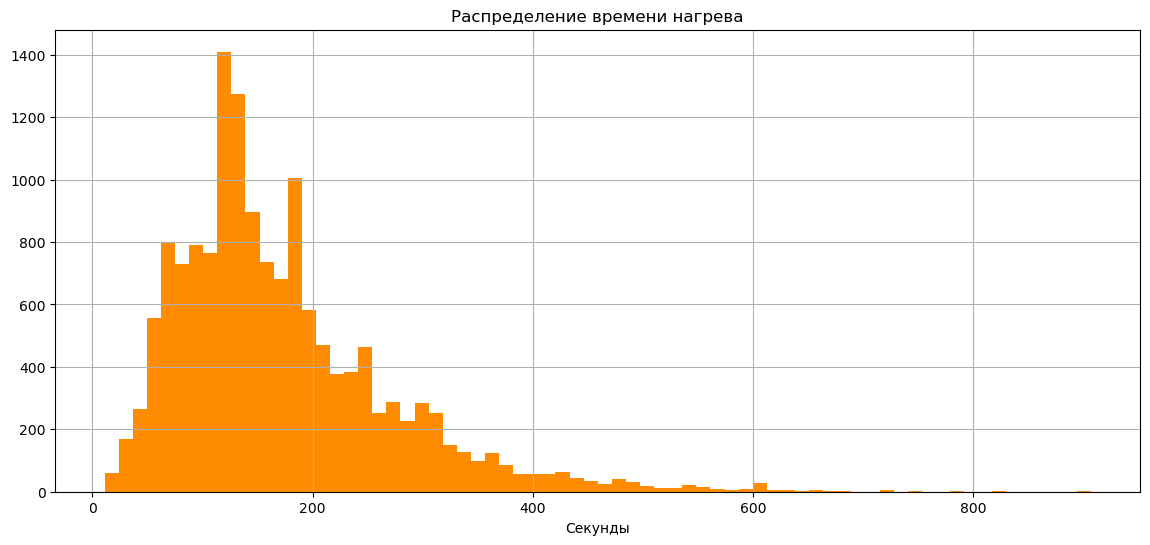

In [25]:
arc.hist("Время нагрева", bins=70, figsize=(14, 6), color='darkorange')
plt.title('Распределение времени нагрева')
plt.xlabel('Секунды')
plt.show()

In [26]:
arc['Активная энергия'] = arc['Активная мощность']*arc['Время нагрева']

In [27]:
energy = arc[['key', 'Активная энергия']].groupby('key', as_index=False).sum()
energy.info()
energy.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3214 non-null   int64  
 1   Активная энергия  3214 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.3 KB


,key,Активная энергия
0,1,628.616930
1,2,395.281800
2,3,581.774624
3,4,543.710274
4,5,412.180480


Первый признак готов, в нём 3214 партий

#### Данные о подаче сыпучих материалов и проволоки
Необходимо заполнить пропуски нулями. Агрегировать данные не нужно, они уже в необходимом виде

In [28]:
bulk.fillna(value=0, inplace=True)
wire.fillna(value=0, inplace=True)
bulk.info()
wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------ 

теперь пропусков нет, в каждой таблице по 3081 партии

#### Результаты измерения температуры
В первую очередь удалим те партии, в которых есть хотя бы один пропуск или в которых есть результаты измерения температуры ниже температуры плвления стали. Таким партиям нельзя доверять

In [29]:
bad_batches = pd.unique(temp[(temp['Температура'].isna())|(temp['Температура']<1300)]['key'])
bad_batches.shape

(743,)

Всего таких партий 743

In [30]:
t = temp['key'].value_counts()
ones = t.index[t==1].tolist()
ones

[195, 279]

In [31]:
bad_batches = np.append(bad_batches, ones)

In [32]:
temp = temp[~temp['key'].isin(list(bad_batches))]
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13903 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13903 non-null  int64  
 1   Время замера  13903 non-null  object 
 2   Температура   13903 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 434.5+ KB


На всякий случай переведем дату и время в соотвествующий формат и отсортируем в пределах каждой партии.

In [33]:
temp['Время замера_dt'] = pd.to_datetime(temp['Время замера'], format='%Y-%m-%d %H:%M:%S')
temp.sort_values(['key', 'Время замера_dt'], inplace = True)

Теперь берём первую и последнюю запись в пределых каждой партии, что будет соответсвовать начальной и конечной температурам

In [34]:
first_last_temp = temp[['Температура', 'key']].groupby(by = 'key', as_index=False).agg(['first', 'last'])
first_last_temp.info()
first_last_temp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Температура, first)  2471 non-null   float64
 1   (Температура, last)   2471 non-null   float64
dtypes: float64(2)
memory usage: 57.9 KB


Температура        
          first    last
key                    
1        1571.0  1613.0
2        1581.0  1602.0
3        1596.0  1599.0
4        1601.0  1625.0
5        1576.0  1602.0

#### Объединение в один датафрейм

In [35]:
df = first_last_temp['Температура'].\
merge(wire, on='key', how='inner').\
merge(bulk, on='key', how='inner').\
merge(gas, on='key', how='inner').\
merge(energy, on='key', how='inner')
df.head()

,key,first,last,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Активная энергия
0,1,1571.0,1613.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,628.616930
1,2,1581.0,1602.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,395.281800
2,3,1596.0,1599.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,581.774624
3,4,1601.0,1625.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,543.710274
4,5,1576.0,1602.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,412.180480


In [36]:
df.describe()

,key,first,last,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Активная энергия
count,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.0,2325.000000,2325.000000,...,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000,2325.000000
mean,1251.512258,1587.365161,1593.366022,102.412198,17.605637,3.240481,0.307077,0.0,0.980504,0.006371,...,0.021075,0.445591,5.061505,4.252473,208.507957,1.069247,153.971613,120.026667,11.378942,539.273463
std,715.099053,23.623144,11.209581,43.535263,33.642919,27.966585,4.761821,0.0,8.700682,0.205882,...,1.016213,6.225965,20.934742,22.534166,157.137873,14.247231,81.398153,84.674380,6.395632,257.298107
min,1.000000,1519.000000,1541.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,26.187544
25%,629.000000,1571.000000,1587.000000,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282948,368.206194
50%,1255.000000,1587.000000,1593.000000,101.087998,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100950,508.453259
75%,1868.000000,1603.000000,1598.000000,128.069763,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,14.217691,679.062253
max,2499.000000,1660.000000,1653.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,...,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,3718.054401


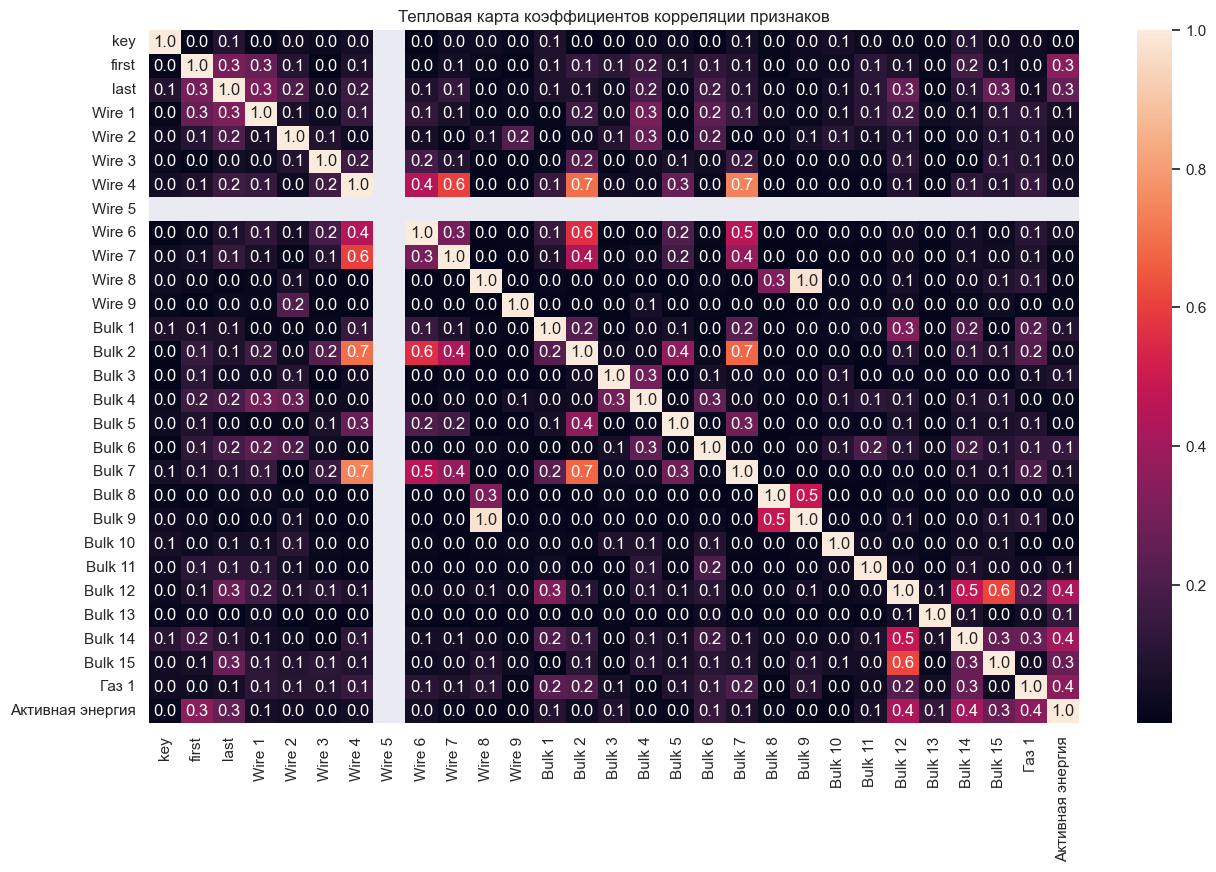

In [37]:
sns.set(rc={'figure.figsize':(15,9)})
sns.heatmap(abs(df.corr()), annot=True, fmt='.1f')
plt.title('Тепловая карта коэффициентов корреляции признаков')
plt.show()

Из тепловой карты матрицы корреляции видно, какие признаки можно удалить. Достаточной считаем корреляцию выше 0.6 по модулю

    Wire 5 - все нули
    Bulk 9 - коррелирует с Wire 8
    Wire 4 - коррелирует с Bulk 2 и Bulk 7
    Bulk 2 - из оставшихся коррелирует с Bulk 7

In [38]:
df.drop(['Wire 5', 'Bulk 9', 'Wire 4', 'Bulk 2'], inplace = True, axis=1)

Рассмотрим распределение оставшихся признаков в конечном датасете

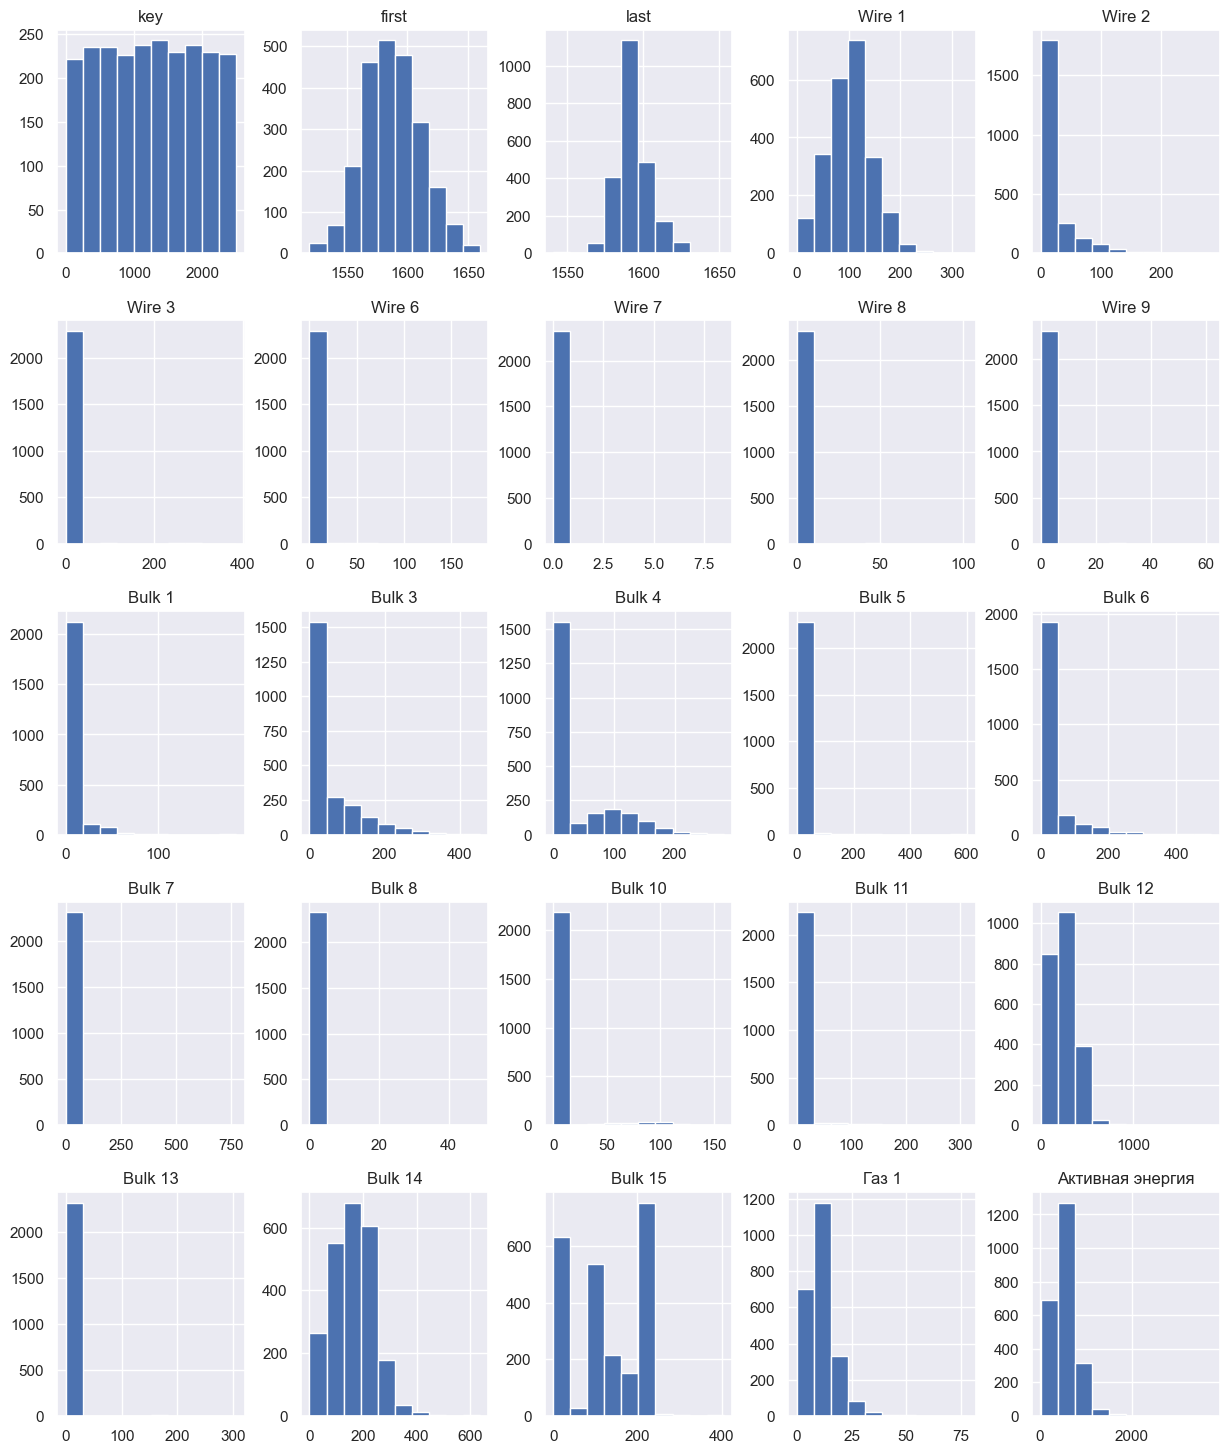

In [39]:
fig = df.hist(figsize=(15,18))
plt.show()

### Обучение моделей

#### Разделение на обучающую и тестовую выборку

In [40]:
features = df.drop(['last', 'key'], axis=1)
target = df['last']

In [41]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=310723)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(1743, 23)
(1743,)
(582, 23)
(582,)


In [42]:
features

,first,Wire 1,Wire 2,Wire 3,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,Bulk 3,...,Bulk 7,Bulk 8,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Активная энергия
0,1571.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,628.616930
1,1581.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,395.281800
2,1596.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,581.774624
3,1601.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,543.710274
4,1576.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,412.180480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,1570.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,21.0,...,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,571.539318
2321,1554.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,675.222467
2322,1571.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,680.326674
2323,1591.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,90.0,...,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,474.918795


#### Обучение моделей

In [43]:
mae = make_scorer(mean_absolute_error, greater_is_better=False)

In [44]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

#### CatBoost

In [45]:
%%time
grid = {'learning_rate': [0.01, 0.03],
        'depth': [4, 6, 8, 10]}

catboost = GridSearchCV(
    CatBoostRegressor(verbose=1000), 
    scoring=mae,
    param_grid=grid, 
    cv=4)
catboost.fit(features_train, target_train)

0:	learn: 11.5716934	total: 275ms	remaining: 4m 34s
999:	learn: 7.7344286	total: 1.54s	remaining: 0us
0:	learn: 11.0863853	total: 2.39ms	remaining: 2.38s
999:	learn: 7.4799039	total: 1.27s	remaining: 0us
0:	learn: 11.4223008	total: 1.83ms	remaining: 1.82s
999:	learn: 7.8009761	total: 1.27s	remaining: 0us
0:	learn: 11.4926437	total: 2.01ms	remaining: 2s
999:	learn: 7.6986229	total: 1.3s	remaining: 0us
0:	learn: 11.5229091	total: 1.51ms	remaining: 1.51s
999:	learn: 6.2264266	total: 1.29s	remaining: 0us
0:	learn: 11.0497054	total: 1.63ms	remaining: 1.62s
999:	learn: 6.1094482	total: 1.33s	remaining: 0us
0:	learn: 11.3815866	total: 1.49ms	remaining: 1.49s
999:	learn: 6.2095367	total: 1.31s	remaining: 0us
0:	learn: 11.4484134	total: 1.68ms	remaining: 1.68s
999:	learn: 6.1212874	total: 1.29s	remaining: 0us
0:	learn: 11.5702697	total: 3.21ms	remaining: 3.21s
999:	learn: 7.0441473	total: 2.8s	remaining: 0us
0:	learn: 11.0810119	total: 3.75ms	remaining: 3.75s
999:	learn: 6.7908589	total: 2.87s	

GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000284C1D35340>,
             param_grid={'depth': [4, 6, 8, 10], 'learning_rate': [0.01, 0.03]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [46]:
catboost_model = catboost.best_estimator_
catboost.best_score_

-6.638502066483461

In [47]:
catboost.best_params_

{'depth': 6, 'learning_rate': 0.01}

#### Случайный лес

In [48]:
%%time
grid = {'n_estimators': [100, 200, 300],
        'max_depth': [4, 6, 8]}

forest = GridSearchCV(
    RandomForestRegressor(), 
    scoring=mae,
    param_grid=grid, 
    cv=4)
forest.fit(features_train, target_train)

Wall time: 34.7 s


GridSearchCV(cv=4, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [49]:
forest_model = forest.best_estimator_
forest.best_score_

-6.770830917886057

#### Константная модель

In [50]:
constant = DummyRegressor(strategy='mean')
constant.fit(features_train, target_train)
cross_val_score(constant, X=features_train, y=target_train, scoring=mae).mean()

-8.241897804033389

На кросс-валидации константная модель, как и ожидалось, показывает результаты хуже, чем другие

### Тестирование модели

CatBoost показала хорошие результаты, примем её за окончательную и протестироуем на тестовой выборке

In [51]:
mean_absolute_error(catboost_model.predict(features_test), target_test)

6.173967791784996

In [52]:
mean_absolute_error(constant.predict(features_test), target_test)

7.816307941633993

На тестовой выборке выбранная модель показывает результаты лучше, чем константная

#### Исследование важности признаков

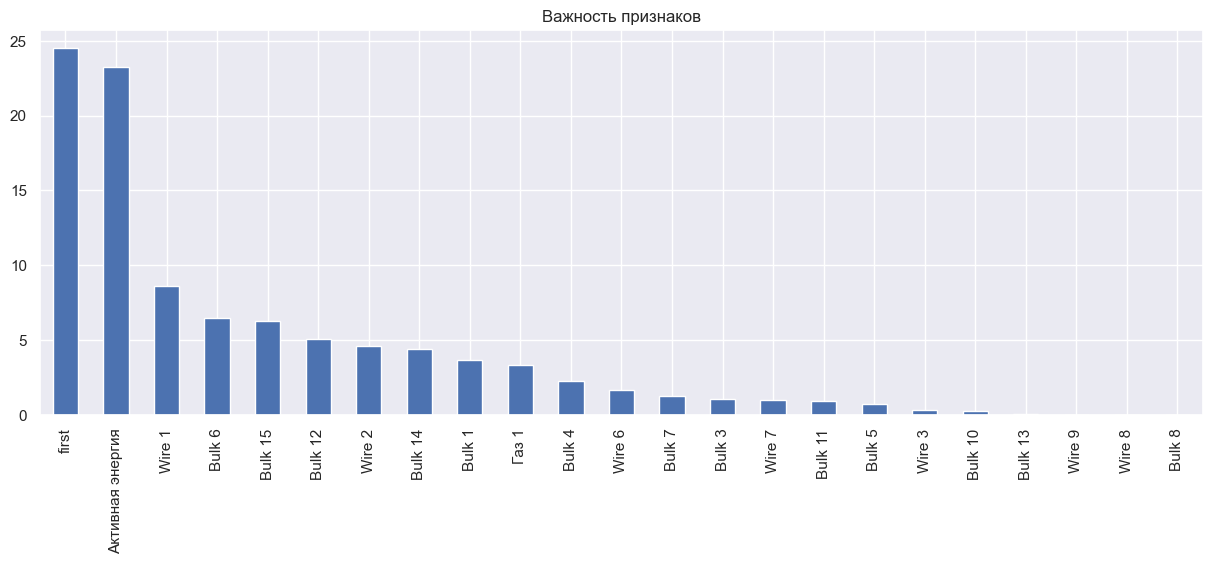

In [53]:
pd.Series(catboost_model.get_feature_importance(), features.columns).sort_values(ascending=False).plot.bar(figsize=(15,5))
plt.title("Важность признаков")
plt.show()

Как и ожидалось, конечная температура зависит по большей части от начальной температуры и количества энергии, затраченной на нагрев

## Отчёт

1. Сравнение решения и плана

В целом решение совпадает с планом. Но изначально планировалось очистить обучающую выборку от выбросов, в процессе решения решено было оставить её в первоначальном виде, так как это данные из реальной практики и было бы некорректно не обучить модель и на них.

2. Трудности

Основные трудности возникли на этапе предобработки данных - много непредвиденных обстоятельсв, при которых замеры в партии нельзя считать корректными, например, слишком низкая температура или всего один замер температуры в партии.

3. Ключевые шаги решения


       1. Было дано 7 датасетов, которые было необходимо подготовить к формировнию таблицы признаков. В данных с мощностями было проведено агрегирование по партиям. В данных о подаче сыпучих материалов, газа и проволоки пропуски были заполнены нулями. В данных с температурой были удалены все партии, значения в которых могли быть неверными (есть пропуски и слишком низкие температуры), затем было проведено агрегирование для получение первого и последнего замера
       2. Для данной задачи были проверены две модели - CatBoost и Случайный лес. Критерием качества служил MAE. На кросс-   валидации модель CatBoost показала немного лучший результат и была выбрана для дальнейшего тестирования. Гиперпараметры,   которые были подобраны: {'depth': 6, 'learning_rate': 0.01}. Сравнение с константной моделью на тестовой выборке даёт        адекватные результаты - CatBoost: 6.2, Константная модель: 7.8
       
4. В качетве признаков для моделей служили активная энергия, переданная партии (Активная мощность * время нагрева), все данные о подаче газа, сыпучих материалов и проволоки, где пропуски были заполнены нулями, и начальная температура. В процессе исследования признаков некоторые из них были удалены, так как или перестали иметь значения, или сильно коррелировали с другими. В итоге на вход модели подавалось 23 признака
       
5. Рекомендации по улучшению решения

Для получения лучших результатов можно перебрать больше гиперпараметров, но это займет намного больше времени. Так же можно использовать нейросети, данные достаточно объёмные, так что обучиться на них не составит труда. Для расширения набора признаков можно запросить дополнительные, например, физичесие и химичесие свойсва выплавляемой в каждой партии стали